# 📊 Pure Quantitative Trading Strategy

## Introduction

This notebook serves as a hands-on walkthrough of the end-to-end process for developing a **purely quantitative trading strategy**, inspired by the methodology outlined in *"[Still in Development.]"* The strategy design follows a well-defined, systematic framework designed to streamline the development pipeline.

As with other experiments in this repository, we leverage **Mini_lib** — our in-house research framework — to simplify and modularize key steps in quantitative research applied to financial data. This notebook is structured around the following core stages:

1. **Data Processing**  
   This stage encompasses feature extraction, labeling, sampling, and data sanitization. Its primary goal is to uncover potential sources of alpha and exploitable patterns in raw market data — essentially deciding *where to dig*.

2. **Signal Extraction**  
   Here we perform feature selection, model training, and hyperparameter tuning. This stage focuses on extracting predictive signals — *using the right tools to dig efficiently*.

3. **Strategy Tuning**  
   This includes signal filtering, position sizing, and stop-loss rules. The goal is to refine raw signals into actionable trades — *separating gold from dirt*.

4. **Risk Management**  
   This involves hedging and portfolio optimization to mitigate risk across assets and strategies — *scaling the operation and protecting against downside*.

5. **Backtesting**  
   We run simulations and stress tests to evaluate the strategy's robustness and real-world viability — *verifying if the mine is actually profitable*.

By following this structured pipeline, the notebook aims to provide a clear, modular example of how to build and validate a fully systematic trading strategy — from raw data to performance assessment.


In [1]:
import sys
sys.path.append("..")
import Data as dt
import ChevalParesseux_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## **0. Getting Data and Making Samples**  

The first step in our workflow is to **acquire and preprocess market data**. This involves:  

1. **Fetching historical price data** – Using reliable sources to obtain asset prices.  
2. **Cleaning and preprocessing** – Handling missing values, adjusting for corporate actions, and ensuring consistency.  
   *(Note: The dataset used here is already processed for daily data, so we will skip this step.)*  
3. **Creating research samples** – Splitting the data into **Training**, **Testing**, and **Embargo** sets to prevent overfitting.  

### ⚠️ **Important Note**  
A **testing set** should be used **sparingly**! It is recommended to track the number of times it is accessed to prevent data leakage and ensure unbiased model evaluation.  


In [2]:
# I. Load data
data = dt.load_data(ticker='SPY')
data.index = pd.to_datetime(data['date'])

daily_data = data.resample('D').agg({
    'close': 'last', 
    'open': 'first', 
    'high': 'max', 
    'low': 'min', 
    'volume': 'sum',
    'bid_open': 'first',
    'bid_close': 'last',
}).dropna()

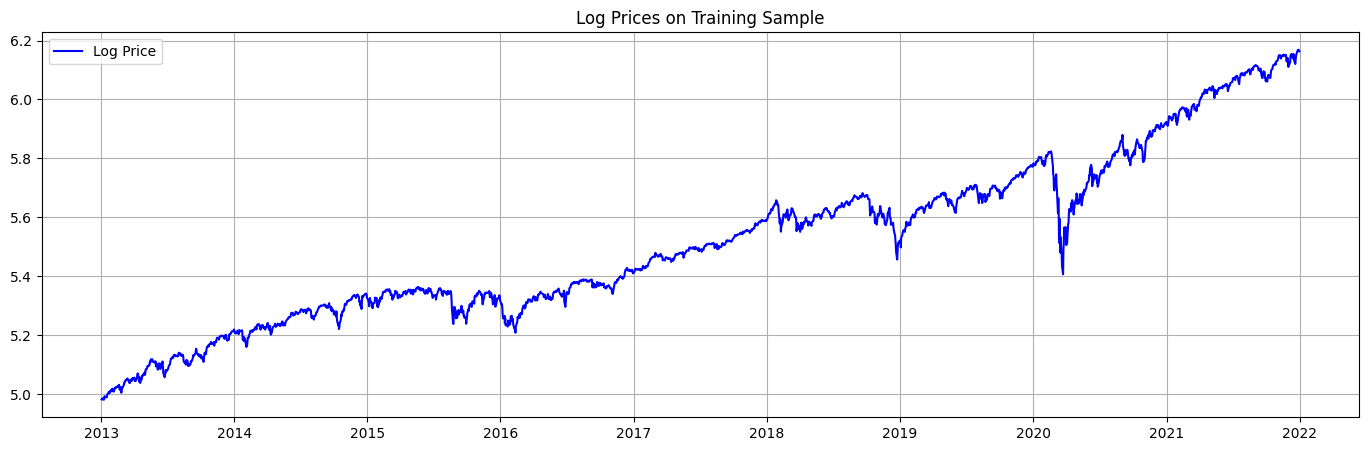

In [3]:
# II. Making Samples (we use a temporal sampling here)
training_data = daily_data.loc['2000-01-01':'2022-01-01'].copy()
testing_data = daily_data.loc['2022-01-01': '2024-10-01'].copy()
embargo_data = daily_data.loc['2024-10-01':].copy()

# III. Let's see the training data we have on a log scale
plt.figure(figsize=(17, 5))
plt.plot(np.log(training_data['close']), label='Log Price', color='blue')
plt.legend()
plt.grid()
plt.title('Log Prices on Training Sample')
plt.show()

---

## **I. Data Processing**

### 🎯 **Objective**  
The objective of this stage is to prepare the dataset for effective model training by performing several key preprocessing steps:

- **Feature Extraction**: Identify and compute features that may carry predictive power.
- **Label Generation**: Create target variables if the task is supervised (classification or regression).
- **Resampling**: Adjust the training data distribution to reflect financial constraints or modeling objectives (e.g., class imbalance, volatility targeting).
- **Sanitization**: Clean and validate the extracted features and labels to ensure consistency and prevent downstream issues.

### ***1. Exploration of the data***

In [4]:
"""
The dataset used here follows a common structure for daily financial data analysis, 
containing the standard HLCV fields — High, Low, Close, and Volume.  

Notably, bid-ask spread information is not available, which means it will need to be implied or approximated 
during the backtesting phase to simulate more realistic execution conditions.
"""
training_data

,close,open,high,low,volume,bid_open,bid_close
date,,,,,,,
2013-01-02,145.82,144.91,146.1575,142.398,192700020.0,144.90,145.81
2013-01-03,145.73,145.91,146.3700,145.340,142464794.0,145.91,145.72
2013-01-04,146.33,146.00,146.6100,145.670,112735212.0,145.99,146.33
2013-01-07,145.99,145.85,146.4500,145.430,109620278.0,145.85,145.98
2013-01-08,145.62,145.65,146.0370,144.980,122588765.0,145.66,145.58
...,...,...,...,...,...,...,...
2021-12-27,477.26,472.06,477.3100,472.010,48745115.0,472.02,477.19
2021-12-28,476.87,477.72,478.8100,476.060,37207611.0,477.72,477.27
2021-12-29,477.48,476.98,478.5600,475.920,47210684.0,476.98,477.54


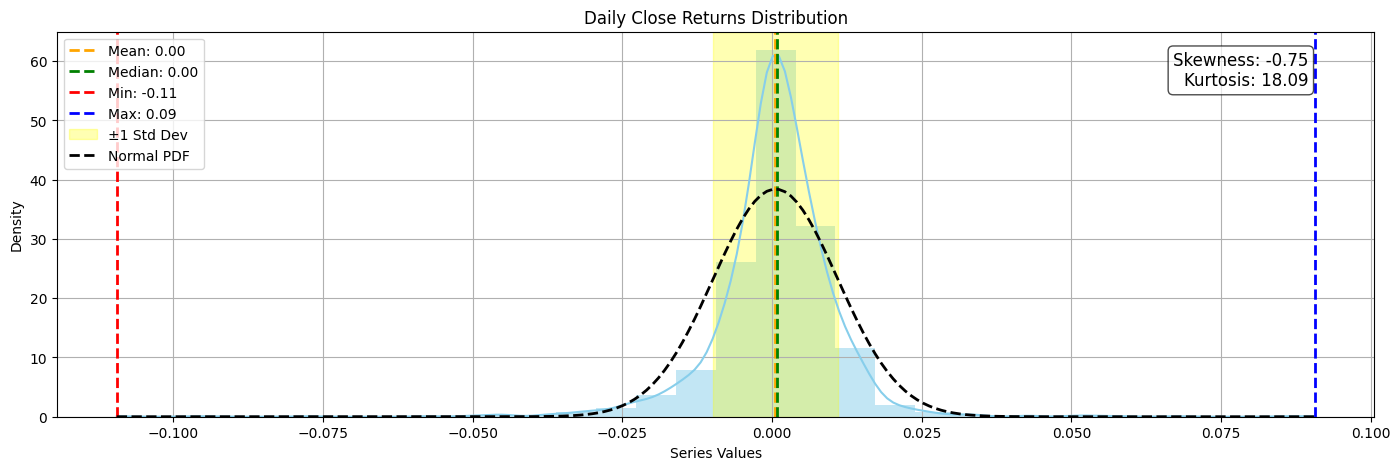

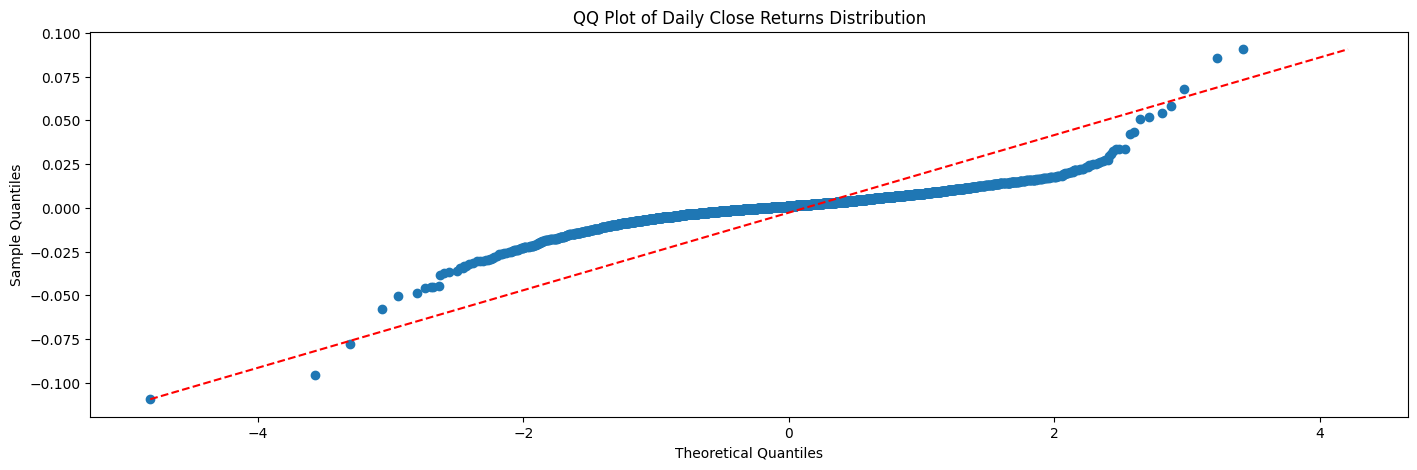

In [5]:
"""
Let's make some plots to deepen our understanding of the data and validate some assumptions.

Analysis : 

- Returns distribution : Many of the financial time series are assumed to be normally distributed, however 
the empirical distribution of returns is often leptokurtic (fat-tailed) and skewed which is the case here.

We'll have to take this into account when we build our model, usually a single model will capture either the 
extreme events or the normal events, but not both.
"""
# I. Plotting the returns series distribution
returns = training_data['close'].pct_change()

lib.plot_series_distribution(series=returns, title='Daily Close Returns Distribution')
lib.plot_QQ(series=returns, title='QQ Plot of Daily Close Returns Distribution')

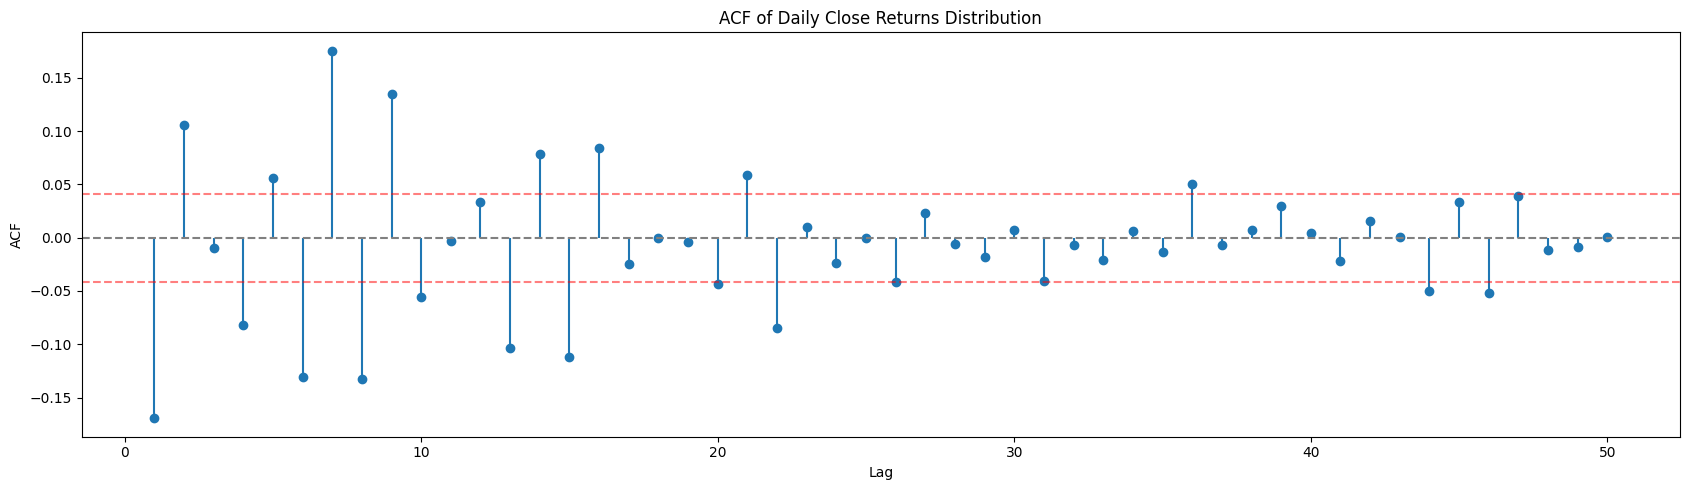

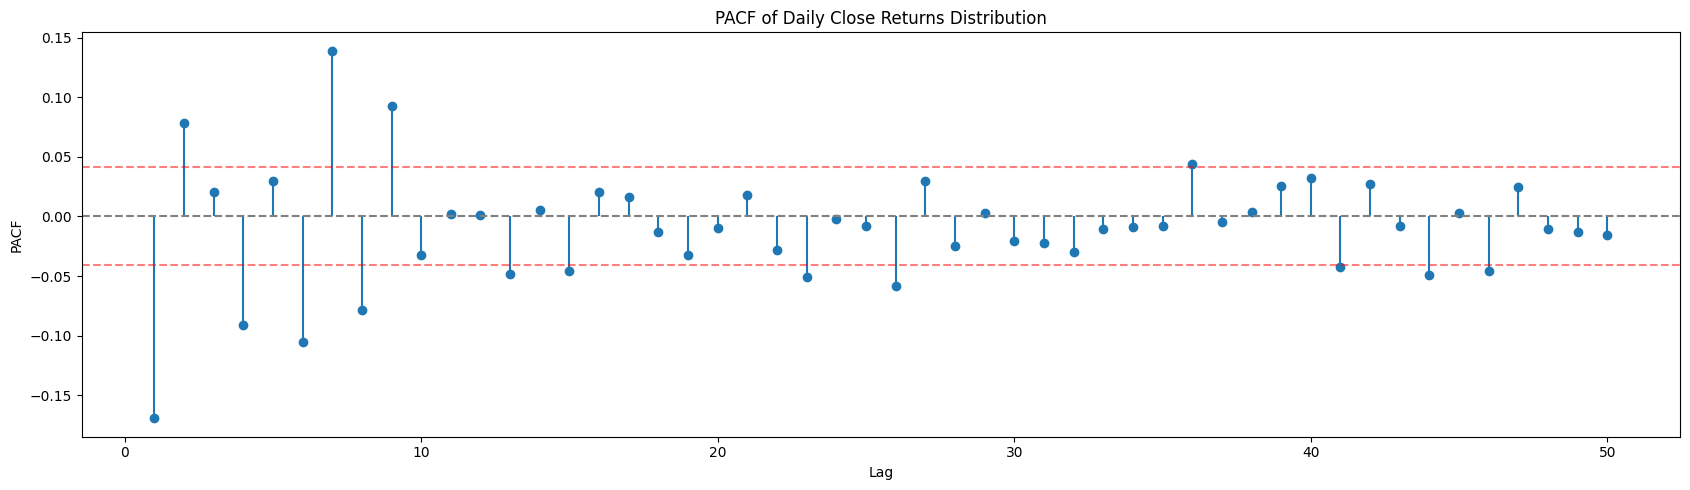

In [6]:
"""
- ACF and PACF : The autocorrelation function (ACF) and partial autocorrelation function (PACF) are used to
determine the order of the ARIMA model. As we can see from the ACF and PACF plots, the returns series mostly
display no significant autocorrelation, which is a common characteristic of financial time series. Still, some
points are significant, indicating that there may be some patterns in the data that could be exploited.
"""
# II. Plotting the ACF and PACF
lib.plot_acf(series=returns, lags=50, title='ACF of Daily Close Returns Distribution')
lib.plot_pacf(series=returns, lags=50, title='PACF of Daily Close Returns Distribution')

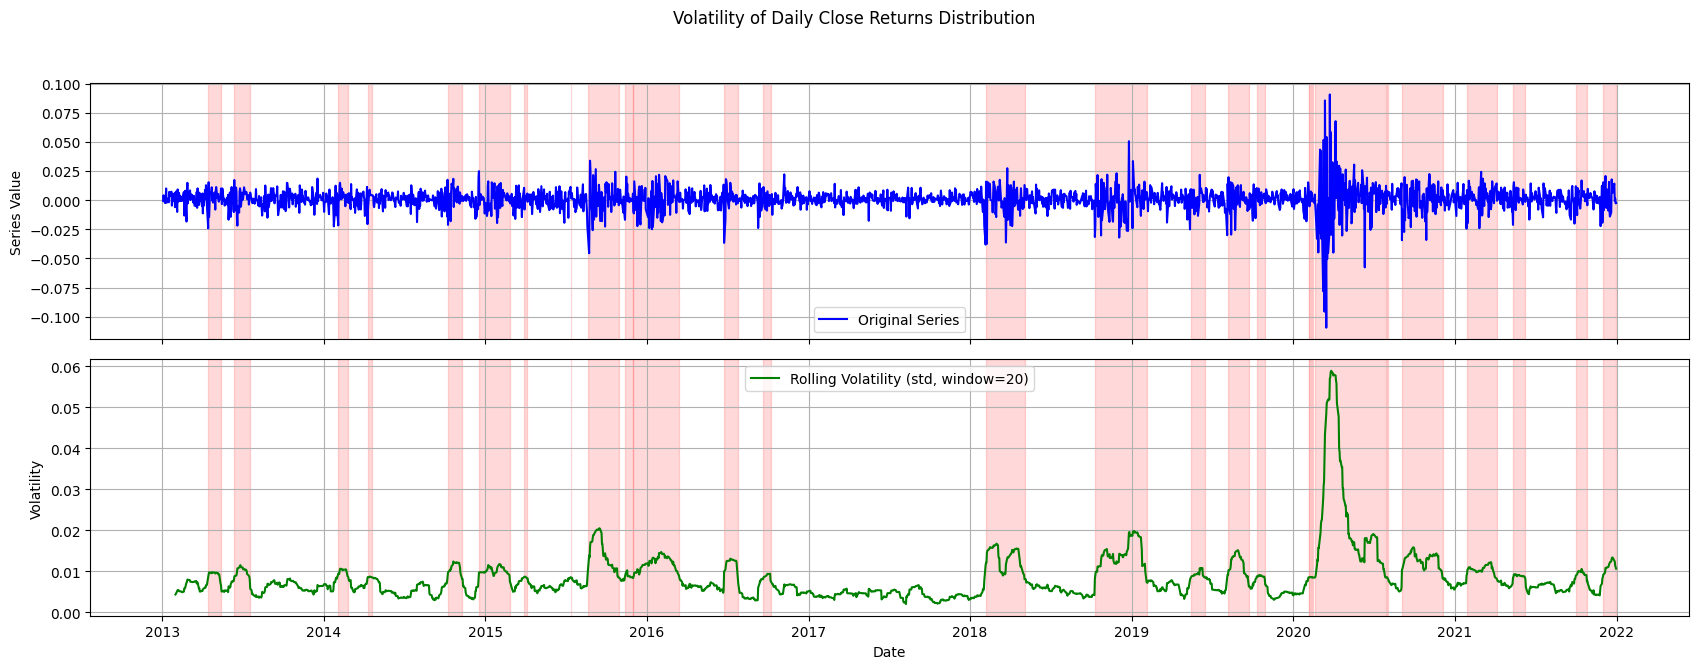

In [7]:
"""
- Volatility clustering : The returns series exhibits volatility clustering, which is a common phenomenon in
financial time series. This means that periods of high volatility are followed by periods of low volatility and vice versa.
As we can see from the plot, the volatility of the returns series is not constant over time and tends to disminish over time.
"""
lib.plot_volatility(series=returns, rolling_window=20, quantile=0.65, figsize=(17, 7), title='Volatility of Daily Close Returns Distribution')

### ***2. Labelling***

### Labeling Strategy

To maintain simplicity, we will later use a **Decision Tree Classifier** as our modeling algorithm. This choice requires the target variable to be represented as **discrete labels** rather than continuous values.

These labels will also serve a dual purpose: they will help us **analyze and interpret the predictive power** of our features.

For this purpose, we will employ the **Triple Barrier Labeling Method**, as introduced by **Marco López de Prado**. This method provides a robust framework for labeling financial time series data by considering both profit-taking and stop-loss barriers, as well as a time-based exit condition.


In [8]:
# ======= I. Set up the labeller =======
labeller = lib.TripleBarrier_labeller()
labeller_params = {
    "upper_barrier": [1.5],
    "lower_barrier": [1],
    "vertical_barrier": [21],
    "vol_window": [21],
    "smoothing_method": ['ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
labeller.set_params(**labeller_params)

# ======= II. Extract the labels =======
labels_df = labeller.extract(data=training_data['close'])
training_data['label'] = labels_df[labels_df.columns[0]]

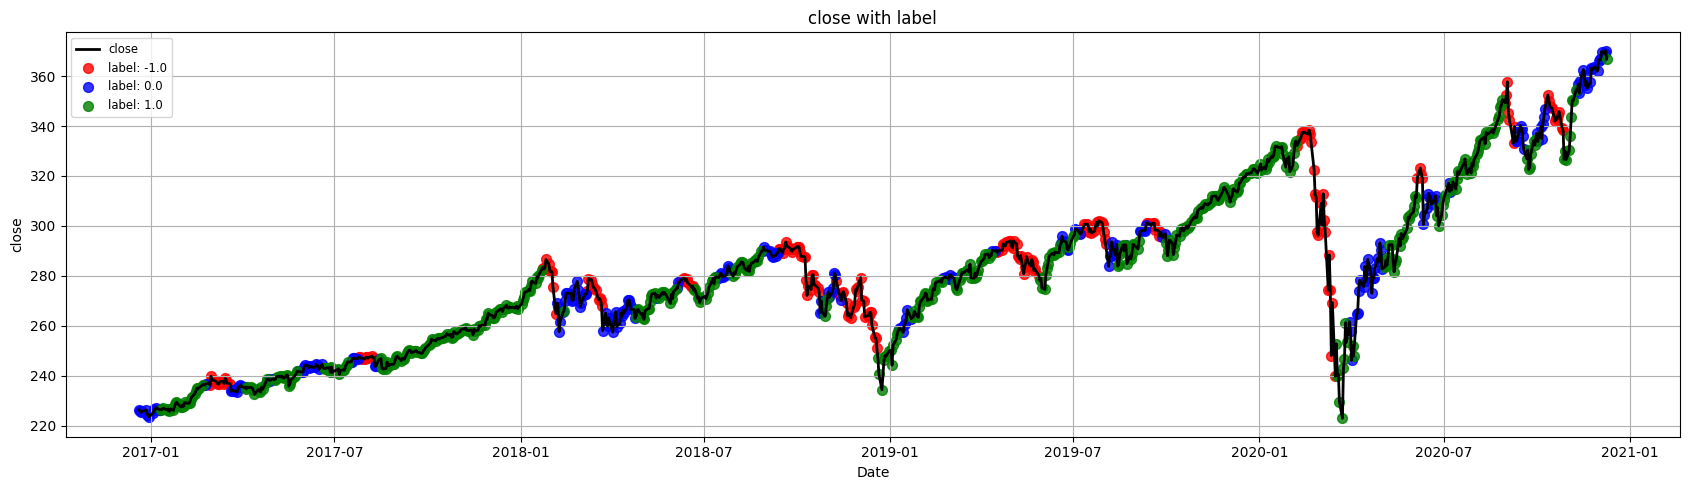

In [9]:
# ======= III. Plot the labels =======
focus_df = training_data.iloc[1000:2000].copy()
lib.plot_series_labels(series=focus_df['close'], label_series=focus_df['label'])

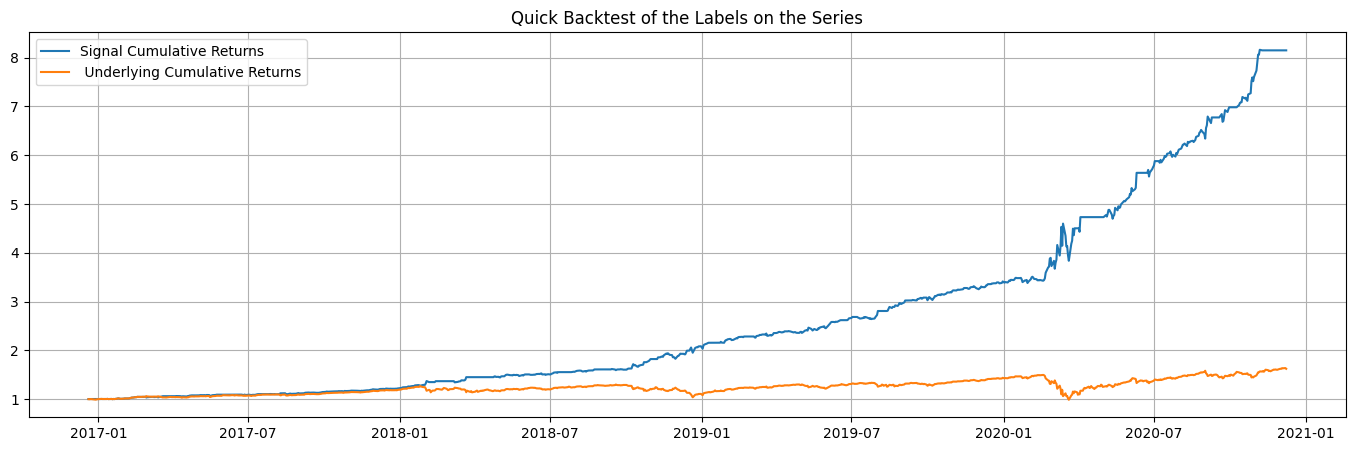

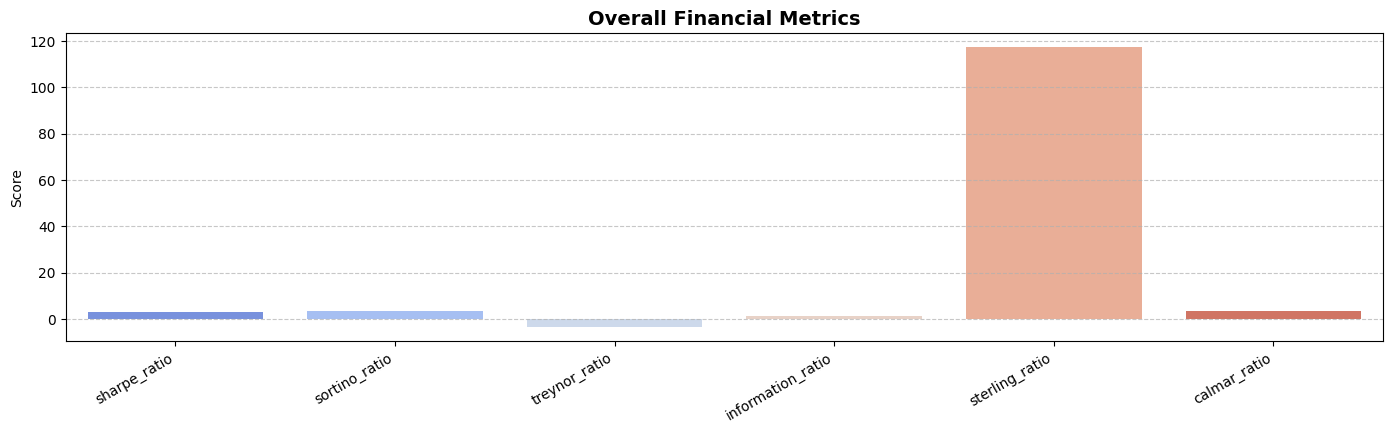

In [10]:
# ======= V. Quick backtest =======
"""
Obviously, usings labels as signals will give insane results as the labels are based on the future data.
Still, it's a nice verificatin of the labeller and the quick backtest function.
"""
lib.plot_quick_backtest(
    series=focus_df['close'],
    signal=focus_df['label'],
    frequence='daily',
    title='Quick Backtest of the Labels on the Series',
    figsize=(17, 5),
)

### ***3. Features Extraction***

### Modeling Approach

To maintain simplicity in our initial model, we aim to capture the common patterns of **momentum**, as reflected in the **autocorrelation** of returns. This base model will focus on the central dynamics of return behavior.

The more extreme behaviors — particularly the **tails of the return distribution** — will be addressed separately through a **meta-model** conditioned on **volatility regimes**. This separation allows us to isolate the core signal from the higher-order risk characteristics.

In [11]:
# Sets the number of jobs to use for parallel processing
n_jobs = 8

In [12]:
# ======= I. Moving Average Based Feature =========
avg_feature = lib.Average_feature(n_jobs=n_jobs)
average_feature_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
avg_feature.set_params(**average_feature_params)

average_feature_df = avg_feature.extract(data=training_data['close'])
training_data = pd.concat([training_data, average_feature_df], axis=1)

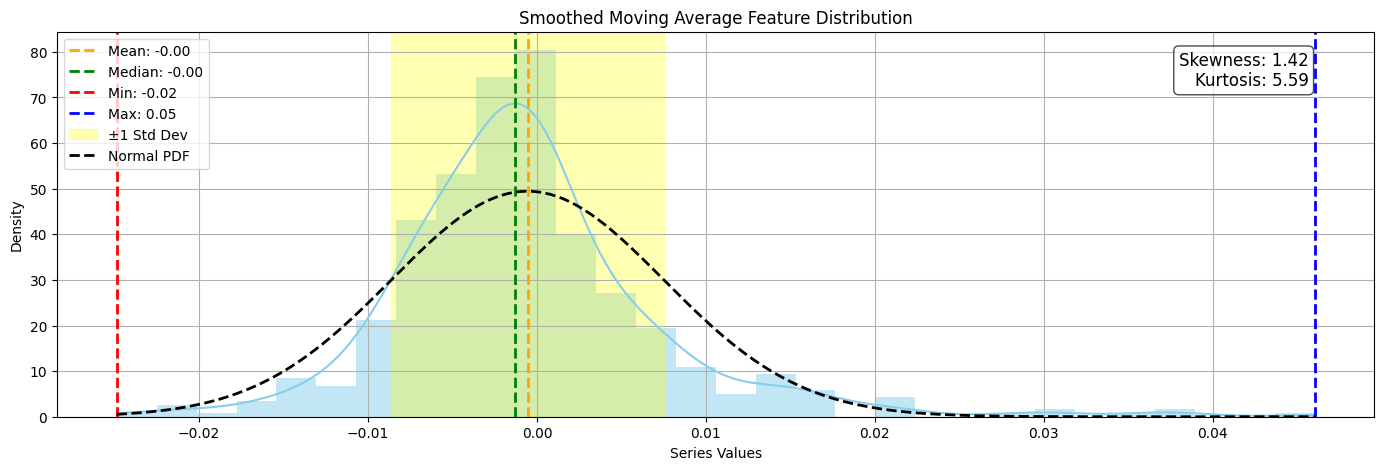

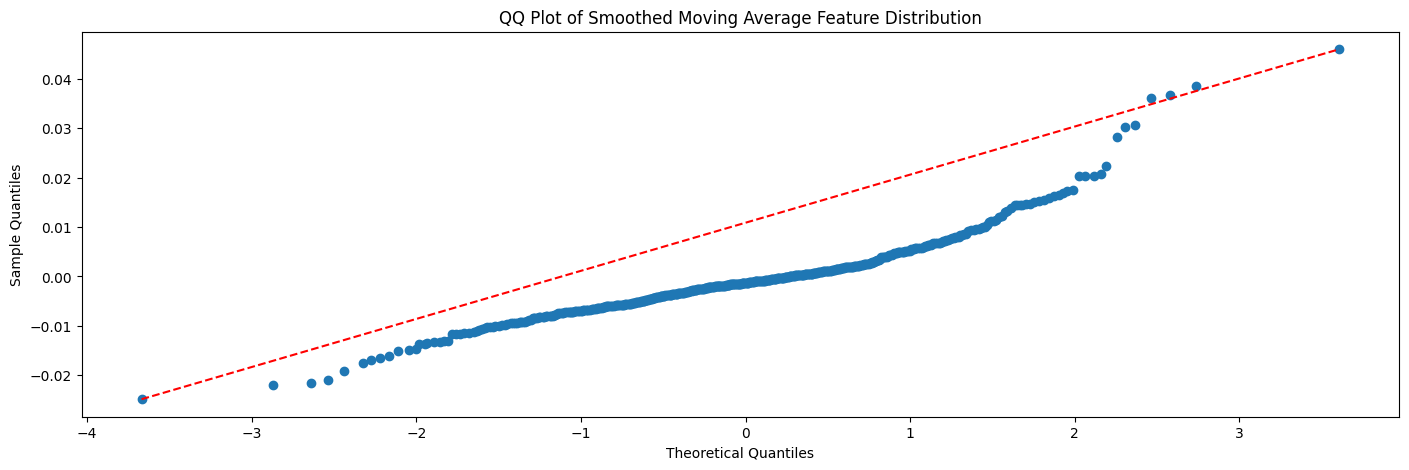

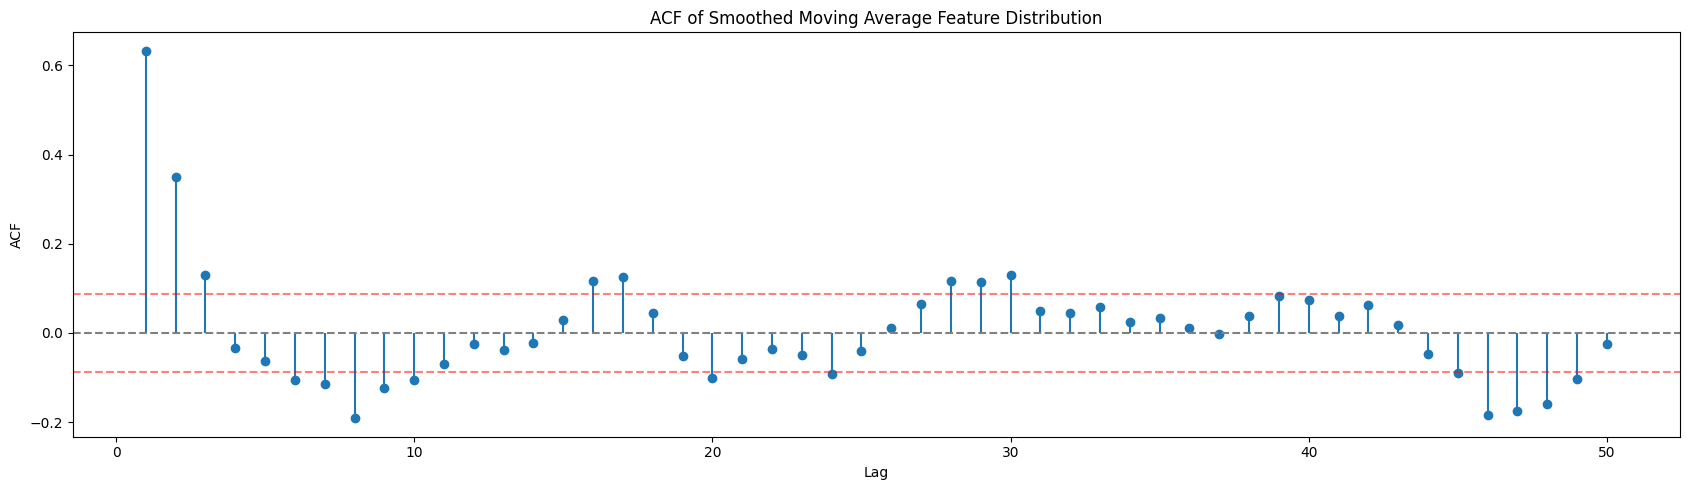

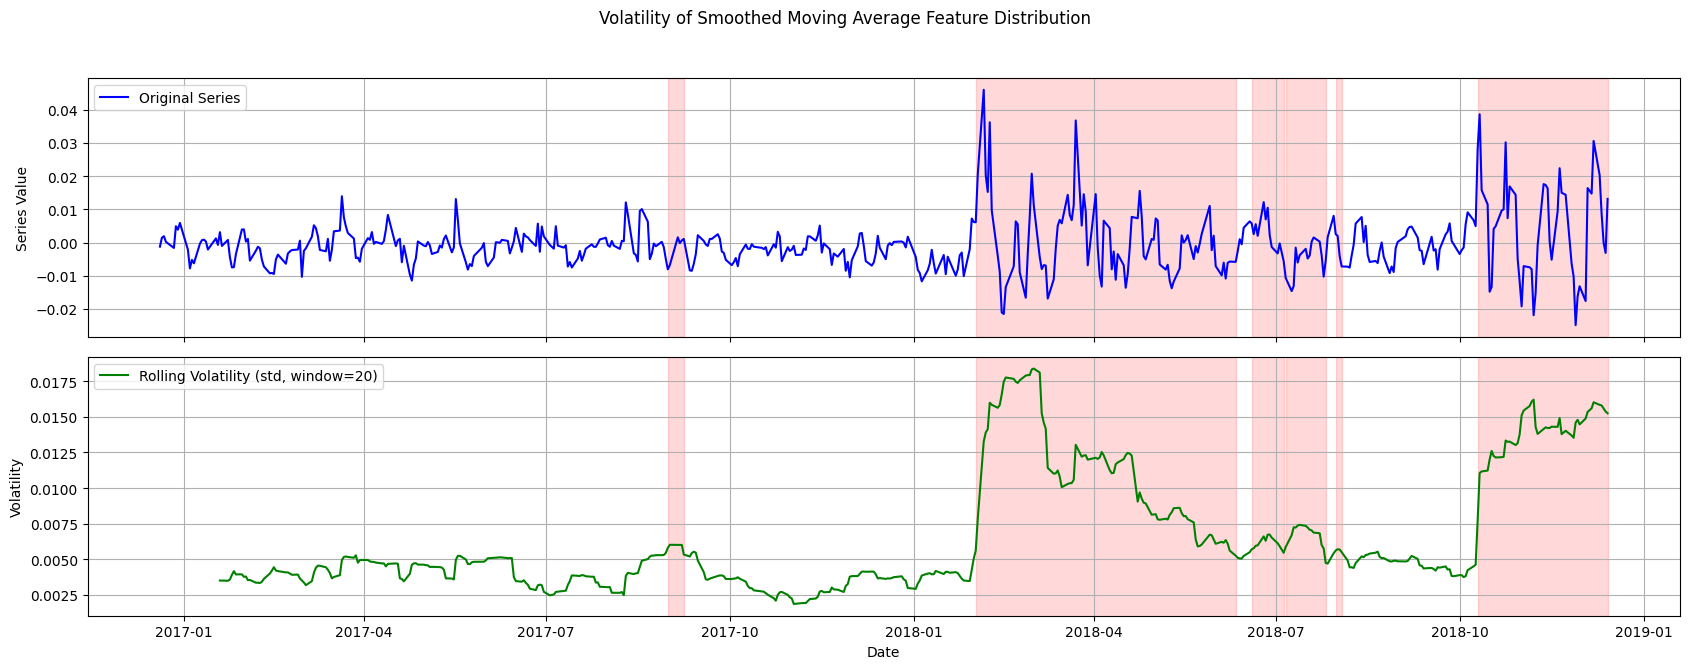

In [13]:
feature_to_plot = average_feature_df.columns[0]
focus_df = training_data.iloc[1000:1500].copy()

lib.plot_series_distribution(series=focus_df[feature_to_plot], title='Smoothed Moving Average Feature Distribution')
lib.plot_QQ(series=focus_df[feature_to_plot], title='QQ Plot of Smoothed Moving Average Feature Distribution')
lib.plot_acf(series=focus_df[feature_to_plot], lags=50, title='ACF of Smoothed Moving Average Feature Distribution')
lib.plot_volatility(series=focus_df[feature_to_plot], rolling_window=20, quantile=0.65, figsize=(17, 7), title='Volatility of Smoothed Moving Average Feature Distribution')

In [14]:
# ======= II. Momentum Based Feature =========
momentum_feature = lib.Momentum_feature(n_jobs=n_jobs)
momentum_feature_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
momentum_feature.set_params(**momentum_feature_params)

momentum_feature_df = momentum_feature.extract(data=training_data['close'])
training_data = pd.concat([training_data, momentum_feature_df], axis=1)

In [15]:
# ======= III. Volatility Based Feature =========
vol_feature = lib.Volatility_feature(n_jobs=n_jobs)
vol_feature_params = {
    "window": [5, 10, 20, 50],
    "smoothing_method": [None, 'ewma'],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
vol_feature.set_params(**vol_feature_params)

vol_feature_df = vol_feature.extract(data=training_data['close'])
training_data = pd.concat([training_data, vol_feature_df], axis=1)

========= Average Feature Example =========


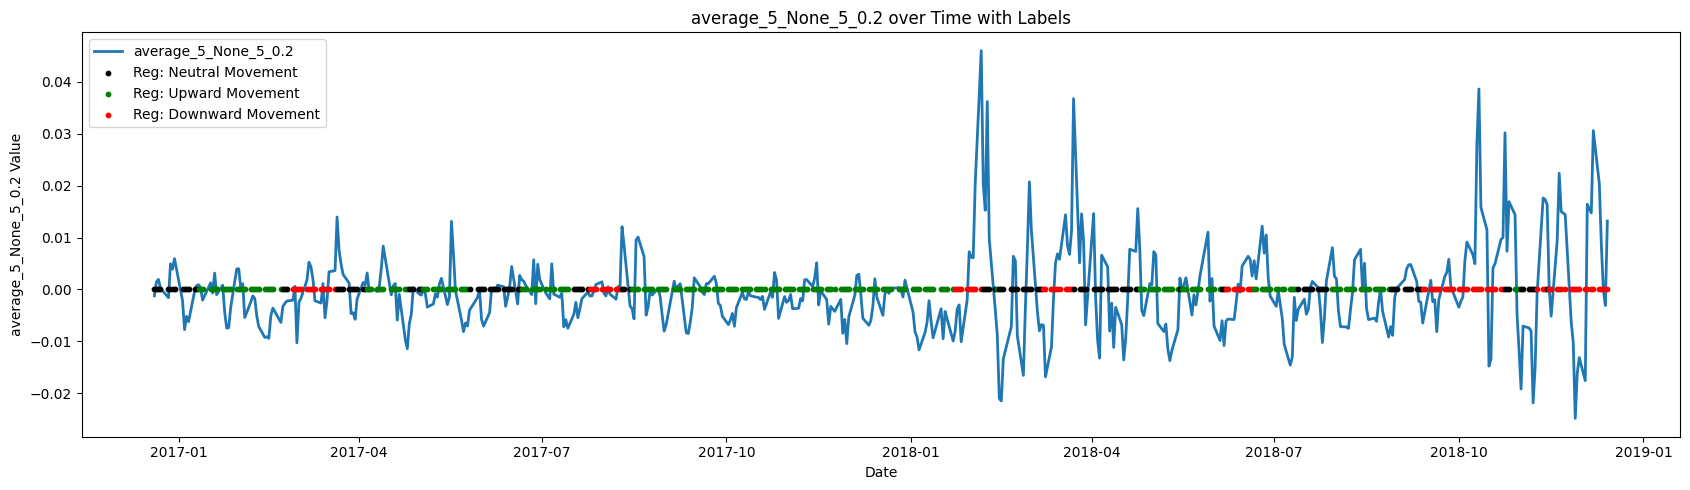

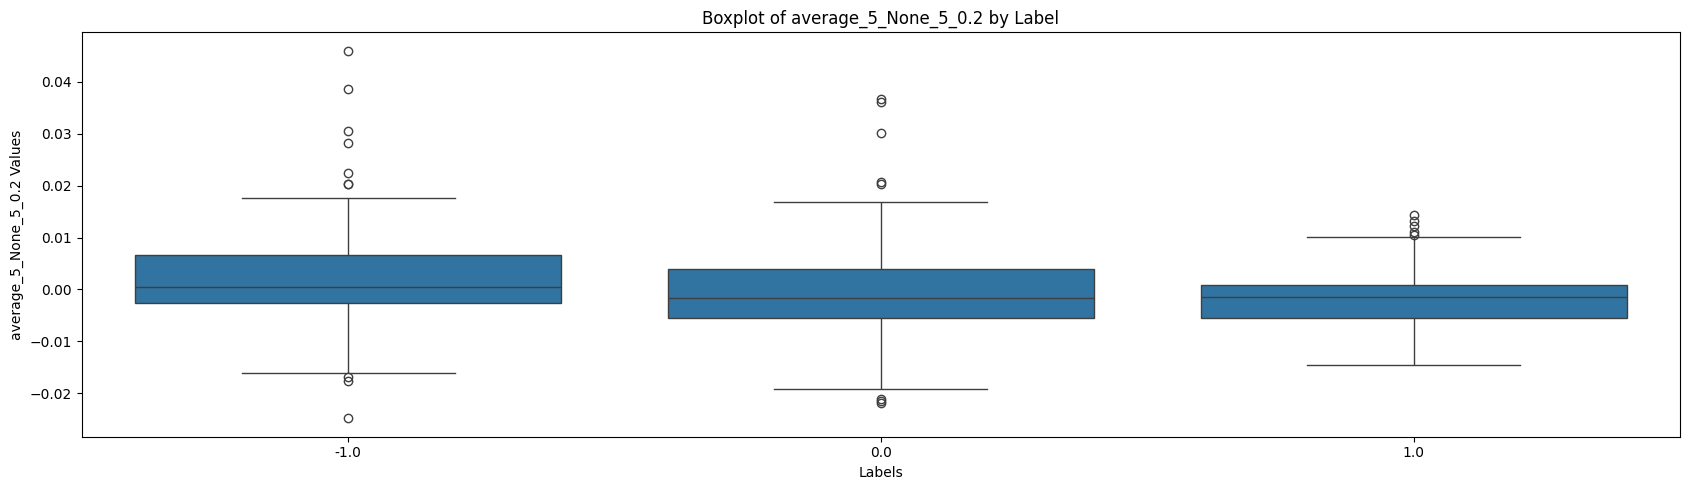

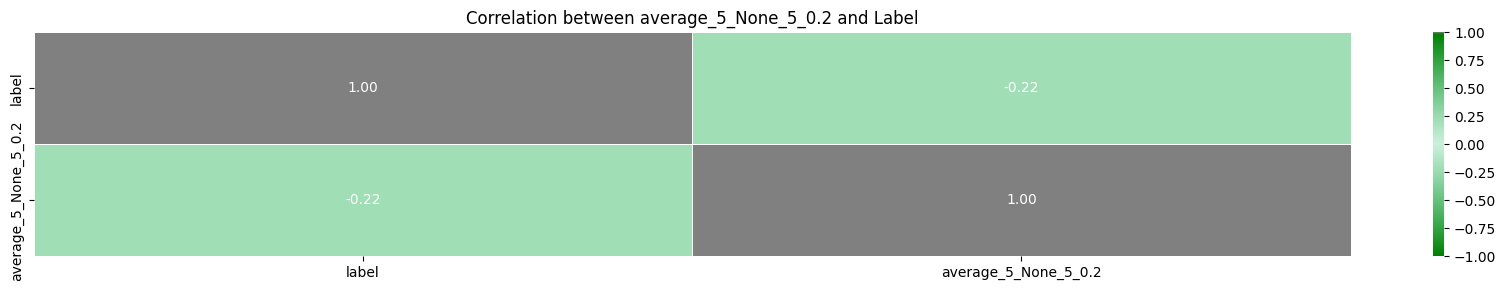

========= Volatility Feature Example =========


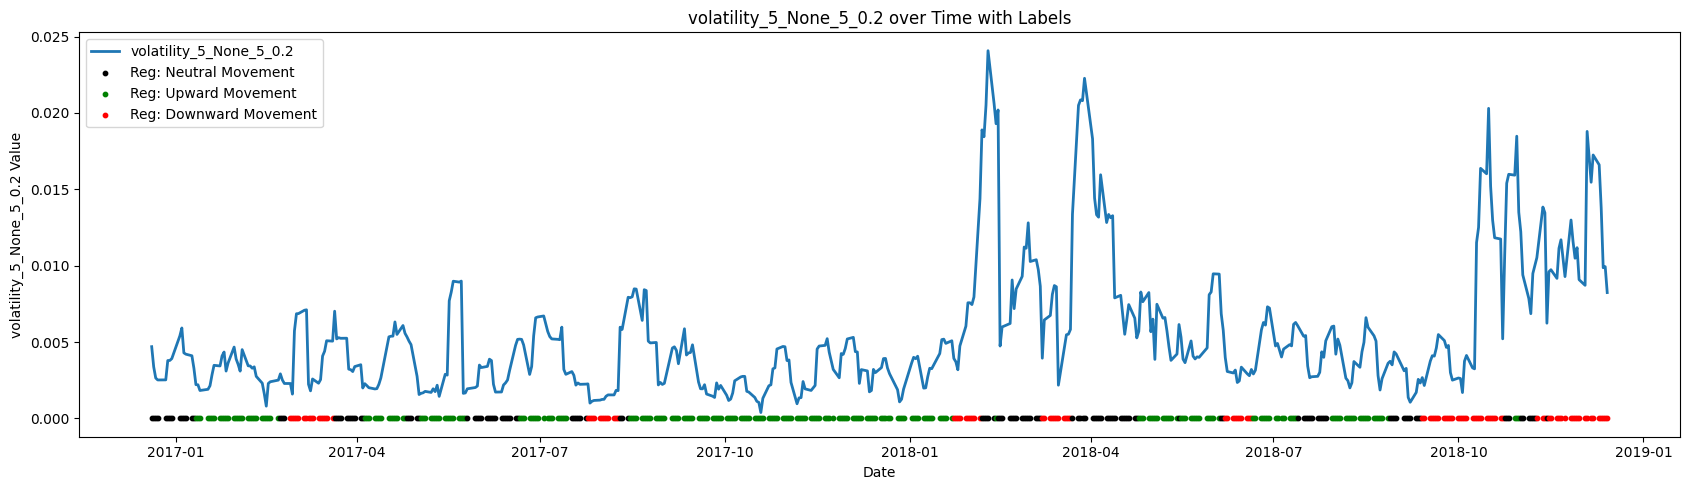

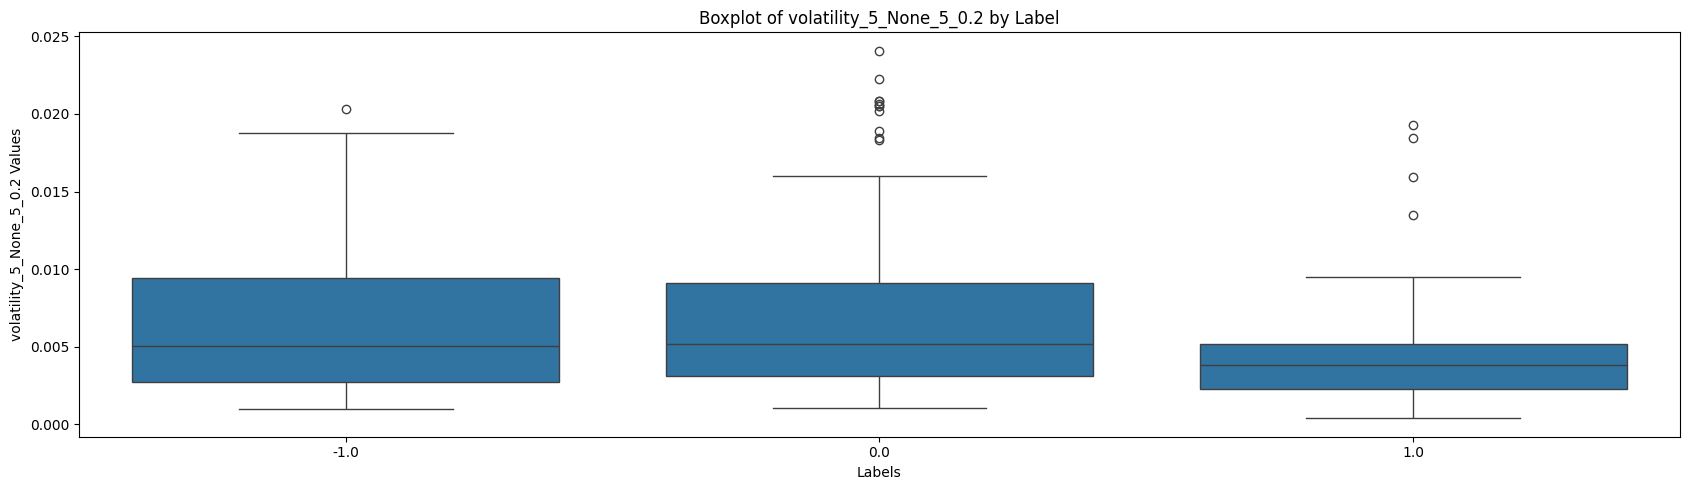

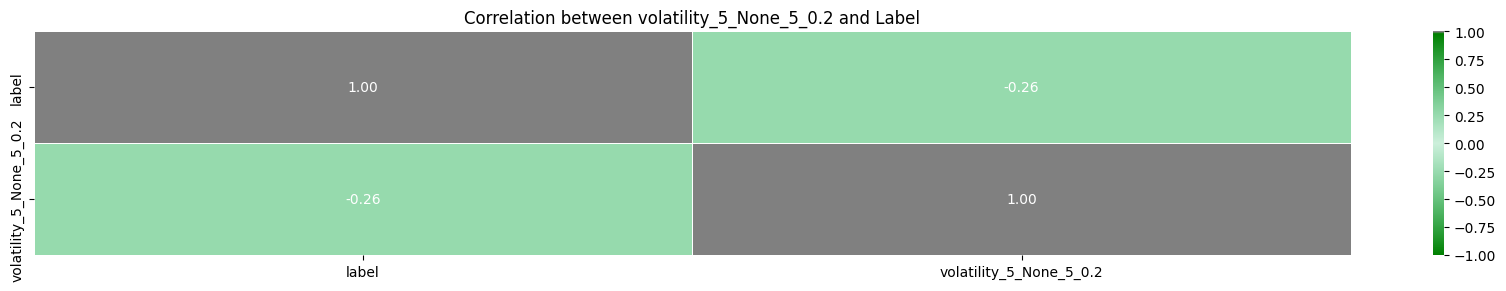

========= Momentum Feature =========


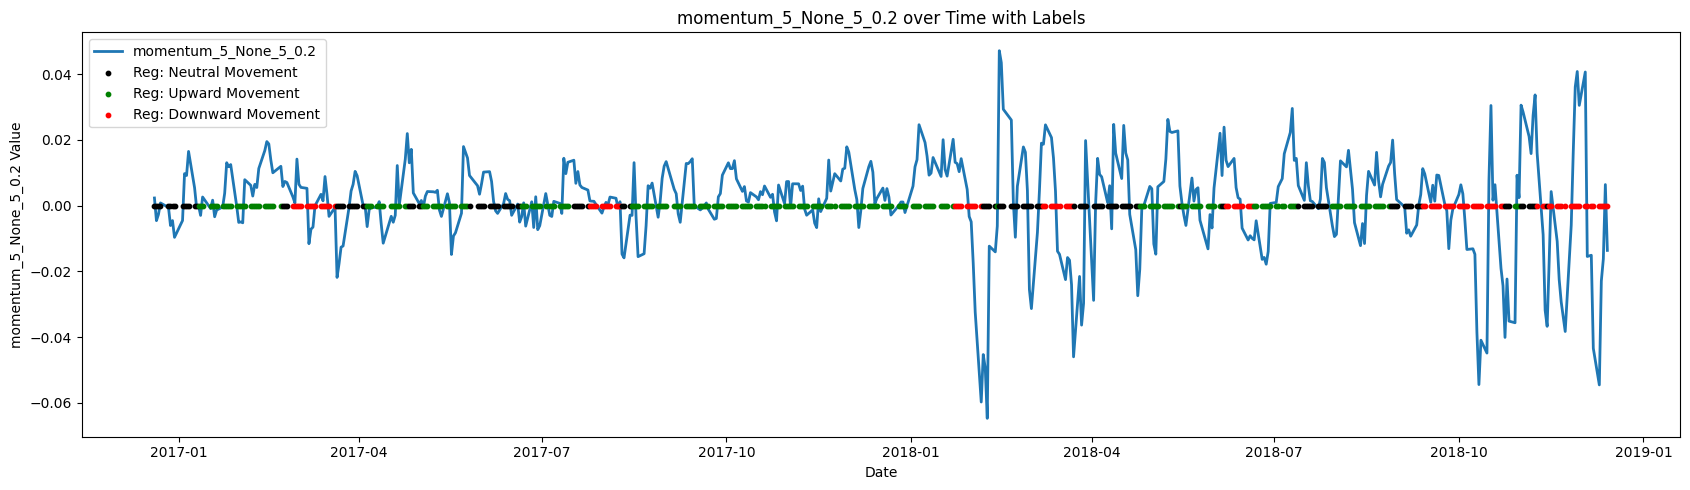

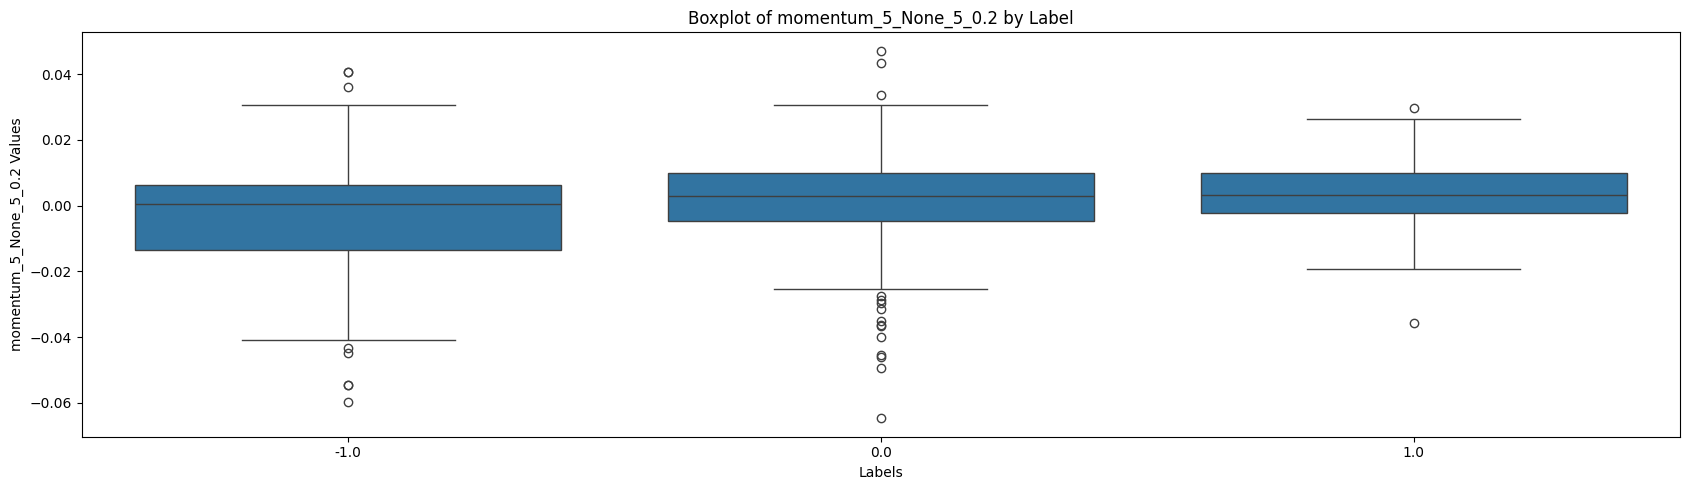

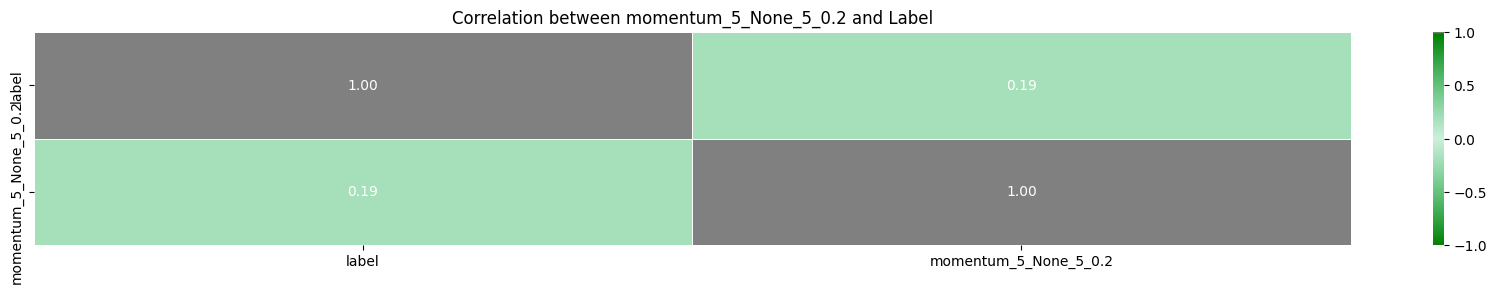

In [16]:
# ======= IV. Plot the Features =========
feature_to_plot_1 = average_feature_df.columns[0]
feature_to_plot_2 = vol_feature_df.columns[0]
feature_to_plot_3 = momentum_feature_df.columns[0]

focus_df = training_data.iloc[1000:1500].copy()

print('========= Average Feature Example =========')
lib.plot_feature_vs_label(feature_series=focus_df[feature_to_plot_1], label_series=focus_df['label'], feature_name=feature_to_plot_1)
print('========= Volatility Feature Example =========')
lib.plot_feature_vs_label(feature_series=focus_df[feature_to_plot_2], label_series=focus_df['label'], feature_name=feature_to_plot_2)
print('========= Momentum Feature =========')
lib.plot_feature_vs_label(feature_series=focus_df[feature_to_plot_3], label_series=focus_df['label'], feature_name=feature_to_plot_3)

### ***4. Sampling***

Using a **discrete labeller** such as the **triple-barrier method** introduces several **sampling biases** that must be addressed:

- **Concurrent labels**: Overlapping events distort true label uniqueness.
- **Imbalanced label distribution**: Can bias the model toward dominant classes.
- **Unequal importance of observations**: Rare but extreme events are critical to model performance due to the heavy-tailed nature of financial returns.

Even if a model performs well on average, **failing to capture rare high-impact events** can lead to **disappointing real-world performance**.

To mitigate these issues, we implement a **resampling strategy** that aims to:

- ✅ **Balance the label distribution**  
- ✅ **Maximize label uniqueness**  
- ✅ **Increase the presence of high-information points** (e.g., large absolute returns)

This ensures a more robust and representative training dataset, especially crucial in financial time series with fat tails and overlapping label signals.


In [17]:
obs_selector = lib.Temporal_uniqueness_selection(n_jobs=1, random_state=72)
obs_selector_params = {
    'label_column': ['label'],
    'price_column': ['close'],
    'n_samples': [3000],
    'replacement': [True],
    'balancing': [False],
    'vol_window': [21],
    'upper_barrier': [1.5],
    'vertical_barrier': [21],
    'grouping_column': [None],
}
obs_selector.set_params(**obs_selector_params)

In [18]:
"""
Extraction of the datasets.

The outputs may sound strange but it makes sense : The main list contains datasets for different parameters (this is done for 
multiple purposes, mainly because it allows to make montecarlo simulations to assess the sensitivity of a model to the sampling parameters).
Each sublist contains avery dataframes used (here we use a unique dataframe for daily data and a unique asset but it could be multiple
assets or intraday data split by date etc...).
"""
# 1. Extract the datasets
training_data['date'] = training_data.index
datasets = obs_selector.extract(data=training_data)
resampled_df = datasets[0][0]

resampled_df = resampled_df.sort_values(by='date').copy()
resampled_df.reset_index(drop=True, inplace=True)
resampled_df

,close,open,high,low,volume,bid_open,bid_close,label,average_5_None_5_0.2,average_5_ewma_5_0.2,...,momentum_50_ewma_5_0.2,volatility_5_None_5_0.2,volatility_5_ewma_5_0.2,volatility_10_None_5_0.2,volatility_10_ewma_5_0.2,volatility_20_None_5_0.2,volatility_20_ewma_5_0.2,volatility_50_None_5_0.2,volatility_50_ewma_5_0.2,date
0,163.31,162.24,164.2953,162.22,96374710.0,162.23,163.30,1.0,-0.009650,-0.009217,...,0.075300,0.003282,0.001321,0.005155,0.001640,0.009003,0.003627,0.007410,0.002930,2013-05-08
1,157.19,157.86,158.9834,155.73,219549337.0,157.86,157.19,1.0,0.024208,0.016055,...,0.016776,0.009757,0.005444,0.011679,0.004582,0.010593,0.003731,0.009260,0.003794,2013-06-24
2,168.79,169.21,169.2800,168.19,84378043.0,169.21,168.78,-1.0,0.000628,0.000978,...,0.015681,0.001903,0.000432,0.002684,0.001170,0.003783,0.002315,0.007851,0.003688,2013-07-30
3,169.93,169.91,170.1800,168.93,103398160.0,169.90,169.91,-1.0,0.000812,0.000509,...,0.026337,0.002834,0.001334,0.003781,0.001360,0.003422,0.001633,0.007918,0.003650,2013-08-08
4,169.01,169.35,170.1000,168.70,91052759.0,169.35,169.01,-1.0,0.004130,0.002339,...,0.028822,0.003129,0.001294,0.004167,0.001569,0.003677,0.001596,0.007942,0.003669,2013-08-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,477.48,476.98,478.5600,475.92,47210684.0,476.98,477.54,0.0,-0.007330,-0.013023,...,0.065648,0.005498,0.002577,0.010939,0.004871,0.011052,0.005101,0.008946,0.004012,2021-12-29
2996,476.16,477.93,479.0000,475.67,45278586.0,477.93,476.33,0.0,-0.001021,-0.009618,...,0.060848,0.006060,0.002480,0.010194,0.004872,0.010685,0.004542,0.008917,0.003921,2021-12-30
2997,476.16,477.93,479.0000,475.67,45278586.0,477.93,476.33,0.0,-0.001021,-0.009618,...,0.060848,0.006060,0.002480,0.010194,0.004872,0.010685,0.004542,0.008917,0.003921,2021-12-30
2998,476.16,477.93,479.0000,475.67,45278586.0,477.93,476.33,0.0,-0.001021,-0.009618,...,0.060848,0.006060,0.002480,0.010194,0.004872,0.010685,0.004542,0.008917,0.003921,2021-12-30


label
 1.0    1261
 0.0    1022
-1.0     717
Name: count, dtype: int64


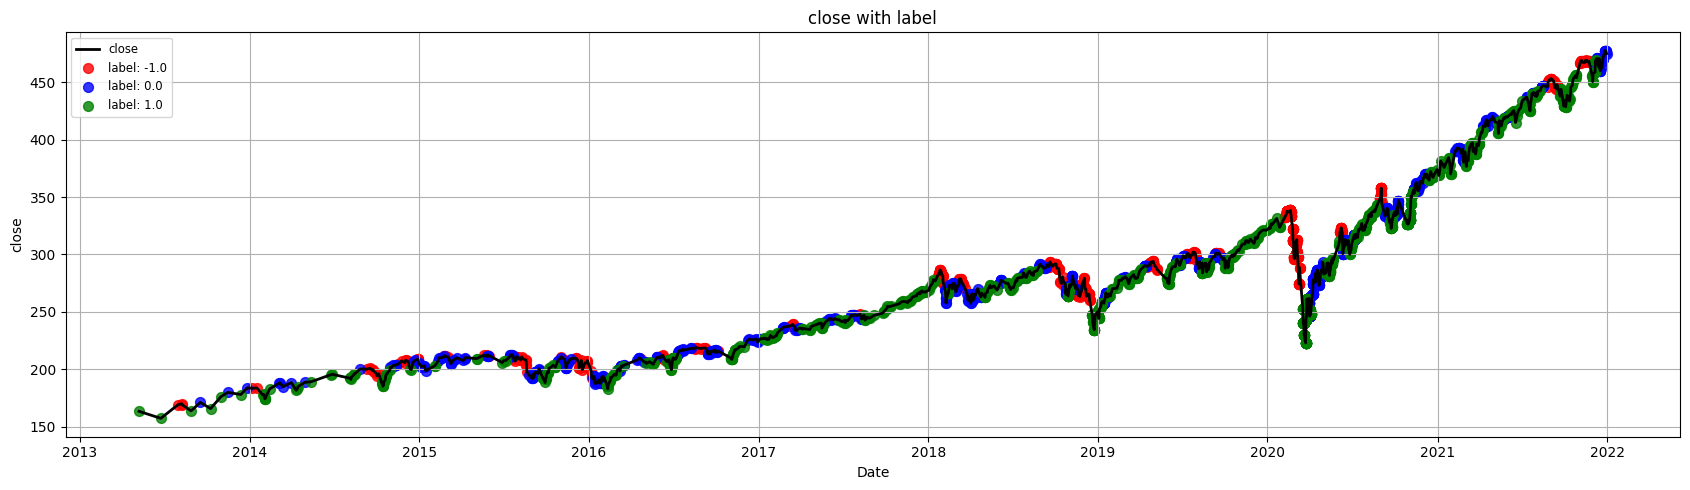

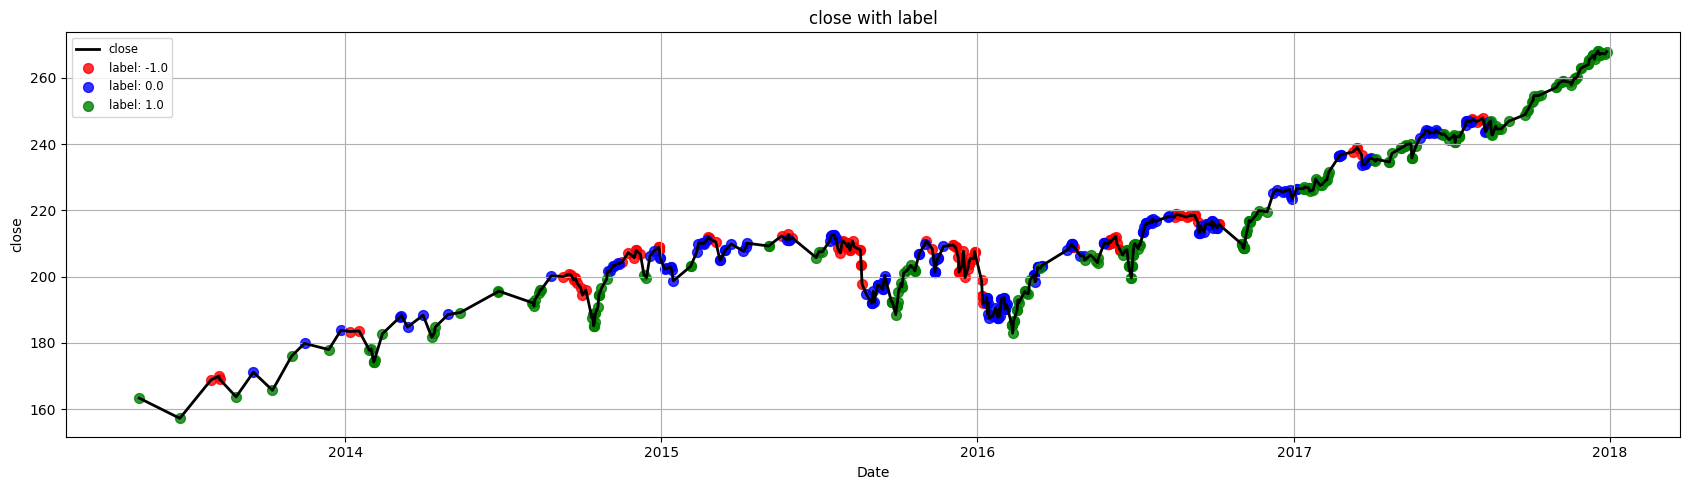

In [19]:
"""
As we can see, the datasets are now balanced. Furthermore, we have more labels as we get close to today and each one reflect a quite important return.
"""
# 2. Overview of the datasets
values_count = resampled_df['label'].value_counts()
print(values_count)

# 3. Plot the datasets
sorted_df = resampled_df.sort_values(by='date').copy()
sorted_df.index = pd.to_datetime(sorted_df['date'])

lib.plot_series_labels(series=sorted_df['close'], label_series=sorted_df['label']) # Whole series

sorted_df = sorted_df.loc['2010-01-01':'2018-01-01'].copy()
lib.plot_series_labels(series=sorted_df['close'], label_series=sorted_df['label']) # Zoomed in series

---

## **II. Signal Extraction**

### 🎯 **Objective**  
The goal of this stage is to extract trading signals from the previously processed dataset by applying a structured modeling workflow. This step transforms engineered features into actionable predictive insights.:

- **Feature Selection**: Identify and retain the most relevant features that contribute significantly to model performance..
- **Predictor Definition**: Select and define the model used to extract the signal from the data. Two broad categories can be considered: Discretionary or Machine Learning.
- **Model Tuning**: Optimize the chosen model’s hyperparameters to improve predictive performance and generalization.

### ***1. Feature Selection***

Even though neural networks are theoretically capable of approximating any function (the Universal Approximation Theorem), in practice, they often inherit biases from the data they are trained on. 

The feature selection process plays a crucial role in mitigating this issue. By carefully selecting relevant input features, we can reduce the risk of overfitting to noisy, irrelevant, or redundant data. This helps the model generalize better to unseen data, leading to improved performance and robustness.

In [20]:
# ----- 1. Feature Selection Model -----
selector = lib.Correlation_selector(n_jobs=n_jobs)
selector_params = {
    'correlation_threshold': [0.9],
}
selector.set_params(**selector_params)

# ----- 2. Fitting Model -----
# non_features = ['date', 'code', 'exchange', 'open', 'high', 'low', 'close', 'volume', 'label']
non_features = ['date', 'close', 'open', 'high', 'low', 'volume', 'bid_open', 'bid_close', 'label']
features_df = resampled_df.drop(columns=non_features).copy()
selector.fit(data=features_df)

nb_features_dropped = len(selector.features_to_drop)
print(f'Number of features dropped : {nb_features_dropped}')
print(f'Features that share a correlation higher than the defined threshold with another one : \n{selector.features_to_drop}')

# ----- 3. Extracting the features -----
training_df = selector.extract(data=resampled_df)
training_df

Number of features dropped : 14
Features that share a correlation higher than the defined threshold with another one : 
{'average_20_None_5_0.2', 'momentum_10_ewma_5_0.2', 'average_10_None_5_0.2', 'momentum_10_None_5_0.2', 'average_20_ewma_5_0.2', 'momentum_50_ewma_5_0.2', 'momentum_5_ewma_5_0.2', 'volatility_20_None_5_0.2', 'volatility_20_ewma_5_0.2', 'volatility_10_None_5_0.2', 'momentum_20_None_5_0.2', 'volatility_50_ewma_5_0.2', 'average_50_ewma_5_0.2', 'momentum_20_ewma_5_0.2'}


,close,open,high,low,volume,bid_open,bid_close,label,average_5_None_5_0.2,average_5_ewma_5_0.2,average_10_ewma_5_0.2,average_50_None_5_0.2,momentum_5_None_5_0.2,momentum_50_None_5_0.2,volatility_5_None_5_0.2,volatility_5_ewma_5_0.2,volatility_10_ewma_5_0.2,volatility_50_None_5_0.2,date
0,163.31,162.24,164.2953,162.22,96374710.0,162.23,163.30,1.0,-0.009650,-0.009217,-0.016166,-0.041459,0.022605,0.074620,0.003282,0.001321,0.001640,0.007410,2013-05-08
1,157.19,157.86,158.9834,155.73,219549337.0,157.86,157.19,1.0,0.024208,0.016055,0.018642,0.030514,-0.052102,0.014849,0.009757,0.005444,0.004582,0.009260,2013-06-24
2,168.79,169.21,169.2800,168.19,84378043.0,169.21,168.78,-1.0,0.000628,0.000978,-0.000674,-0.023981,-0.000059,0.011385,0.001903,0.000432,0.001170,0.007851,2013-07-30
3,169.93,169.91,170.1800,168.93,103398160.0,169.90,169.91,-1.0,0.000812,0.000509,-0.002361,-0.027282,-0.005152,0.024539,0.002834,0.001334,0.001360,0.007918,2013-08-08
4,169.01,169.35,170.1000,168.70,91052759.0,169.35,169.01,-1.0,0.004130,0.002339,0.000048,-0.021615,-0.008855,0.036363,0.003129,0.001294,0.001569,0.007942,2013-08-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,477.48,476.98,478.5600,475.92,47210684.0,476.98,477.54,0.0,-0.007330,-0.013023,-0.017403,-0.028925,0.020933,0.059560,0.005498,0.002577,0.004871,0.008946,2021-12-29
2996,476.16,477.93,479.0000,475.67,45278586.0,477.93,476.33,0.0,-0.001021,-0.009618,-0.017781,-0.025161,0.011815,0.052497,0.006060,0.002480,0.004872,0.008917,2021-12-30
2997,476.16,477.93,479.0000,475.67,45278586.0,477.93,476.33,0.0,-0.001021,-0.009618,-0.017781,-0.025161,0.011815,0.052497,0.006060,0.002480,0.004872,0.008917,2021-12-30
2998,476.16,477.93,479.0000,475.67,45278586.0,477.93,476.33,0.0,-0.001021,-0.009618,-0.017781,-0.025161,0.011815,0.052497,0.006060,0.002480,0.004872,0.008917,2021-12-30


### ***2. Predictor Selection***

In this experiment, we aim to keep things simple and intuitive. That's why we start with a basic yet insightful model: a **Decision Tree Classifier**.

While Decision Trees are easy to interpret and fast to train, they often suffer from high variance and a tendency to overfit, especially when left unpruned. Additionally, they may struggle to capture complex, non-linear relationships in the data.

However, based on our current feature set, which appears to exhibit quasi-linear or regime-like behavior with respect to the target variable, a Decision Tree can still offer meaningful insights and serve as a reasonable baseline.

For improved performance and generalization, I recommend experimenting with more robust ensemble methods such as **Random Forests** or **XGBoost**, which tend to handle overfitting and complex relationships much more effectively.

In [21]:
# ----- 1. Predictor Model -----
predictor = lib.SKL_tree_classifier(n_jobs=n_jobs, random_state=72) # 72o also known as the "beer hand" in poker, a lucky number
predictor_params = {
    'criterion': 'gini',
    'max_depth': 3,
    'min_samples_split': 20,
    'min_samples_leaf': 20,
    'max_features': None,
}
predictor.set_params(**predictor_params)

# ----- 2. Fitting Model -----
non_features = ['date', 'close', 'open', 'high', 'low', 'volume', 'bid_open', 'bid_close', 'label']
X = training_df.drop(columns=non_features).copy()
y = training_df['label'].copy()
predictor.fit(X_train=X, y_train=y)

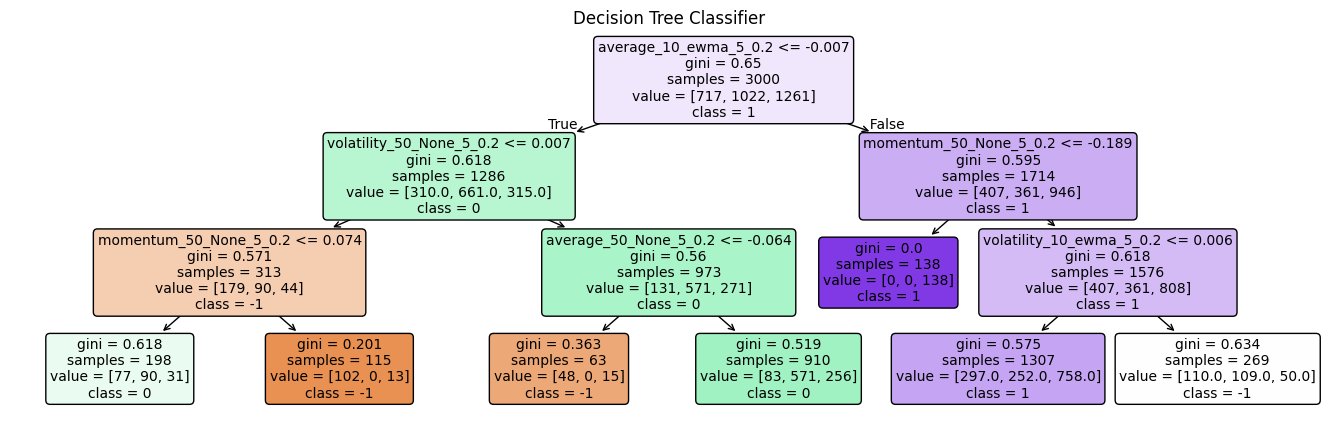

In [22]:
# ----- 3. Plot the tree -----
from sklearn.tree import plot_tree
clf = predictor.decision_tree

plt.figure(figsize=(17, 5))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=['-1', '0', '1'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Classifier")
plt.show()

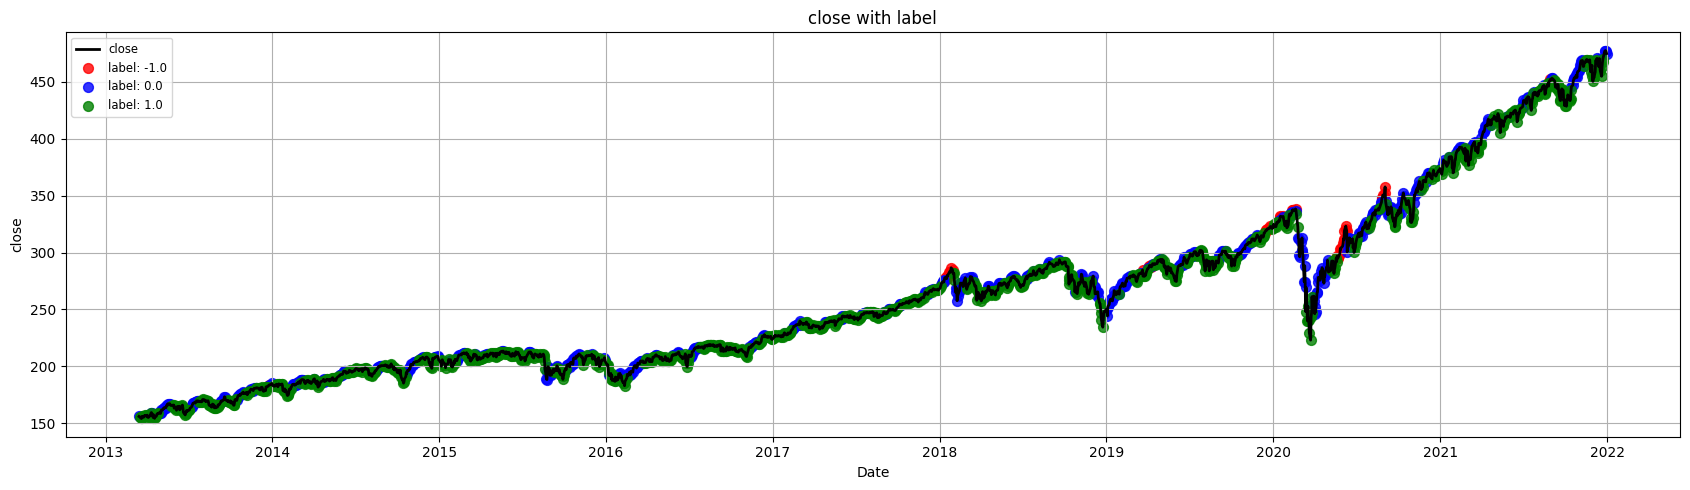

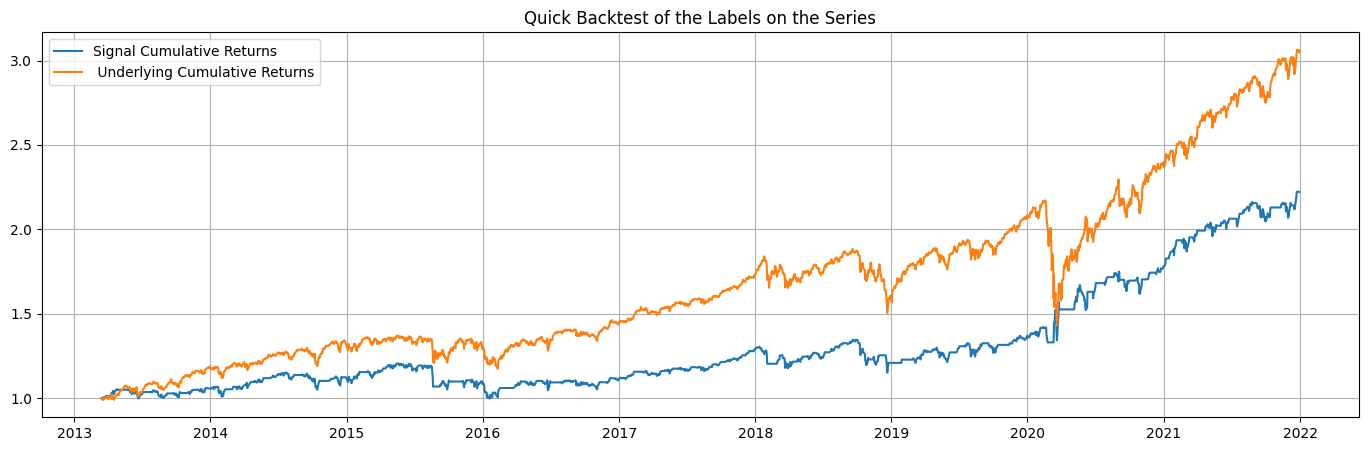

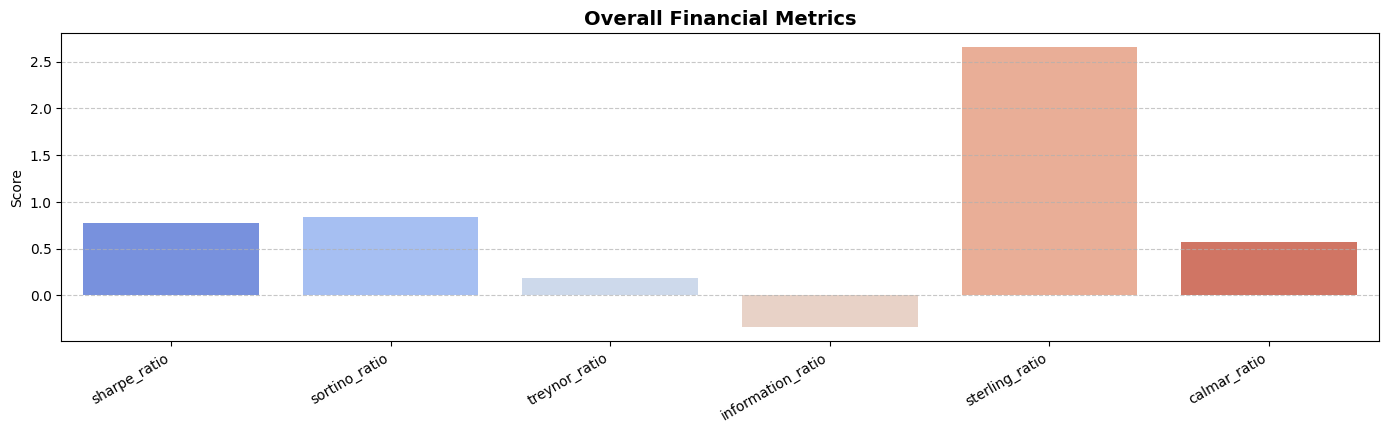

In [23]:
# ----- 3. Quick Backtest -----
#! WARNING : This is a quick backtest on the Training data, the results are not realistic !
quick_data = selector.extract(training_data).dropna().copy()
quick_X = quick_data.drop(columns=non_features).copy()
quick_y = quick_data['label'].copy()

quick_data.loc[:, 'signal'] = predictor.predict(quick_X)
# quick_data = quick_data.iloc[1500:2500].copy()

lib.plot_series_labels(series=quick_data['close'],label_series=quick_data['signal'],)

lib.plot_quick_backtest(
    series=quick_data['close'],
    signal=quick_data['signal'],
    frequence='daily',
    title='Quick Backtest of the Labels on the Series',
    figsize=(17, 5),
)

### ***3. Predictor Tuning***

This step focuses on tuning the predictor model. Nearly all machine learning models are defined by a set of **hyperparameters** that can significantly influence their performance. Finding the optimal combination of these hyperparameters is essential to maximize model effectiveness.

A simple yet effective approach is to perform a **grid search** combined with **cross-validation**. This method allows us to systematically explore different hyperparameter combinations while using cross-validation to assess how well the model generalizes to unseen data.

By doing so, we can identify the best-performing configuration and reduce the risk of overfitting or underfitting.
For this tuning we change the predictor from before : we use a Random Forest in order to have something more robust.

In [24]:
# ----- 1. Tuner Model -----
tuner = lib.Classifier_gridSearch(n_jobs=5, random_state=72)
tuner_params = {
    'random_search': False,
    'n_samples': 0, # useless as we don't use random search
}
tuner.set_params(**tuner_params)

# ----- 2. Fitting Model -----
model = lib.SKL_randomForest_classifier
grid_universe = { # We keep a simple grid universe for the example
    'n_estimators': [100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [20, 50, 100],
    'max_features': [None, 'sqrt', 'log2'],
}
criteria = 'accuracy'

sorted_train_df = training_df.sort_values(by='date').copy()
sorted_train_df.reset_index(drop=True, inplace=True)
features_df = sorted_train_df.drop(columns=non_features).copy()
target_vector = sorted_train_df['label'].copy()

nb_observations = len(sorted_train_df)
n_folds = 3
size_fold = nb_observations // n_folds
data = []
for i in range(0, n_folds):
    idx = i * size_fold
    X_fold = sorted_train_df.iloc[idx:idx + 1000].drop(columns=non_features).copy()
    y_fold = sorted_train_df.iloc[idx:idx + 1000]['label'].copy()
    data.append((X_fold, y_fold))

tuner.fit(model=model, grid_universe=grid_universe, data=data, criteria=criteria)
best_params = tuner.best_params
print(f'With a {criteria} of {tuner.best_score:.2f}, Best parameters : {best_params}')

100%|██████████| 324/324 [03:58<00:00,  1.36it/s]


With a accuracy of 0.41, Best parameters : {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': None}


In [25]:
"""
The cross-validation average score is not the best metric to use here as we have a temporal data and the model is trained on the past data.
But it is still a good metric to use to assess the model performance.
"""
data_train = (features_df, target_vector)
fitted_model = tuner.extract(model=model, data=data_train)

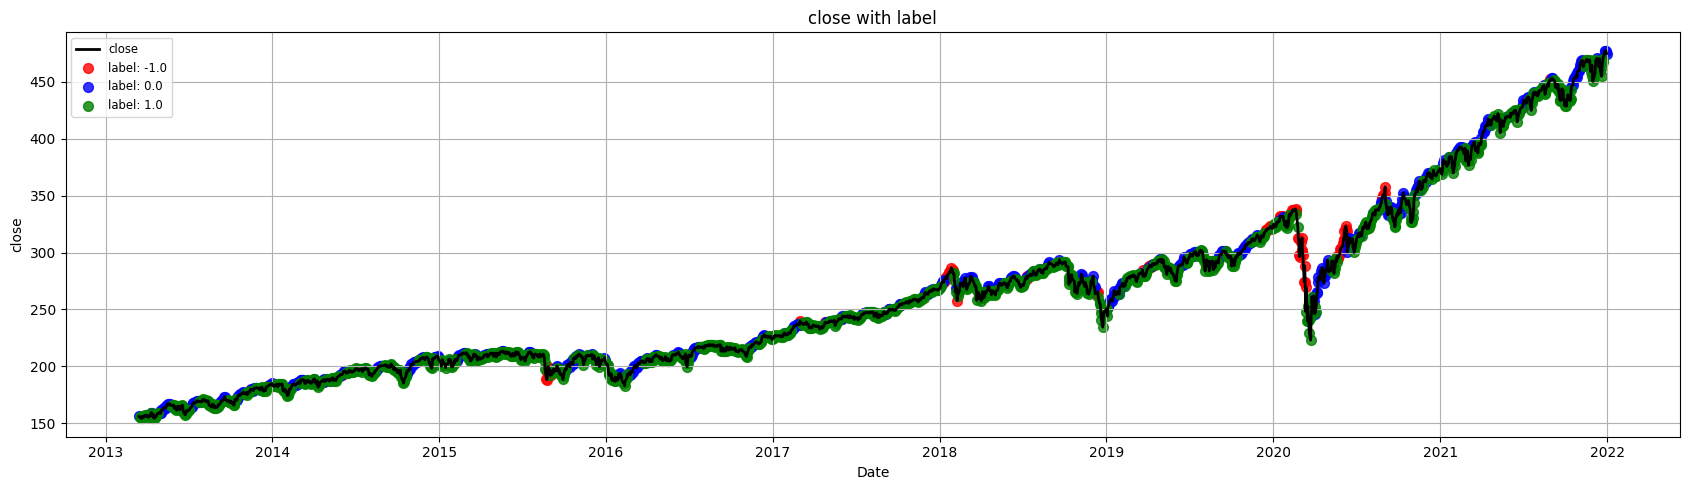

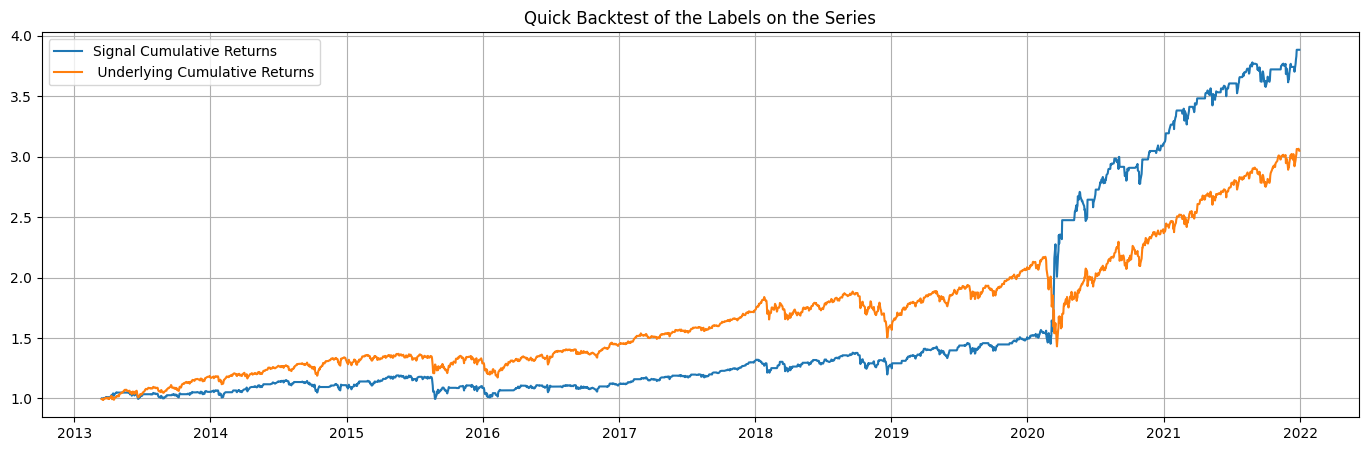

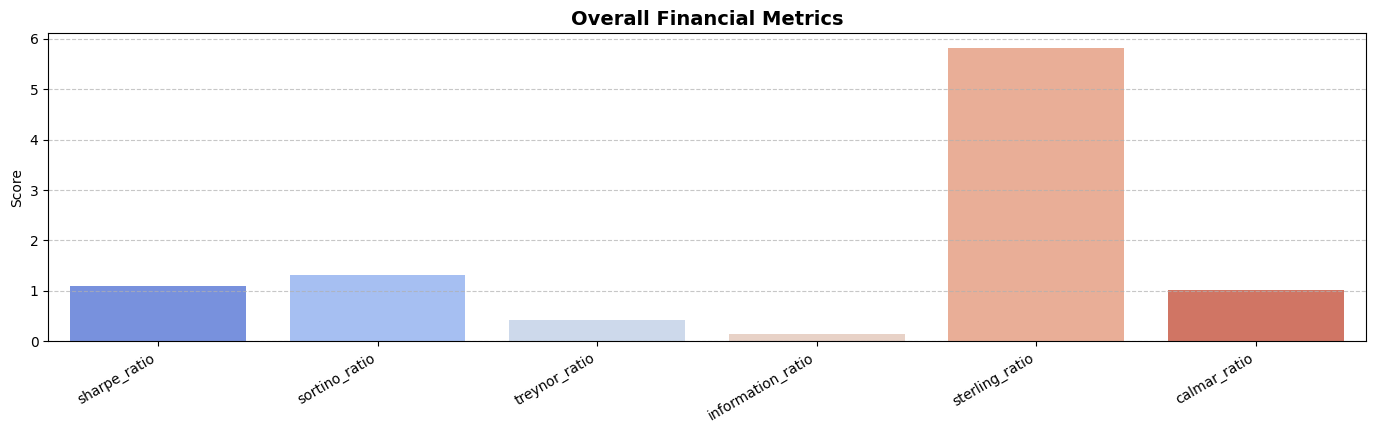

In [26]:
# ----- 3. Quick Backtest -----
#! WARNING : This is a quick backtest on the Training data, the results are not realistic !
quick_data = selector.extract(training_data).dropna().copy()
quick_X = quick_data.drop(columns=non_features).copy()
quick_y = quick_data['label'].copy()

quick_data.loc[:, 'signal'] = fitted_model.predict(quick_X)
# quick_data = quick_data.iloc[1500:2500].copy()

lib.plot_series_labels(series=quick_data['close'],label_series=quick_data['signal'],)

lib.plot_quick_backtest(
    series=quick_data['close'],
    signal=quick_data['signal'],
    frequence='daily',
    title='Quick Backtest of the Labels on the Series',
    figsize=(17, 5),
)

---

## **III. Strategy Tuning**

### 🎯 **Objective**  
The purpose of this stage is to transform raw trading signals into a fully operational strategy. This involves refining the signals, determining position sizing, and applying risk controls.

### 🧩 **Components**

1. **Signal Post-Processing**  
   Apply additional filters or transformations to improve signal quality and robustness:
   - **Confirmation filters**: Require multiple conditions to align before acting on a signal.
   - **Volume filters**: Avoid trading in illiquid conditions by setting a minimum volume threshold.
   - **Volatility regime filters**: Adapt the strategy based on prevailing market volatility.

2. **Position Sizing**  
   Define how much capital to allocate per signal:
   - Fixed fractional sizing
   - Volatility-adjusted sizing
   - Signal strength-based sizing

3. **Stopping Rules**  
   Rules that define when to halt or exit the strategy:
   - Maximum drawdown limits
   - Flat-volatility or low-liquidity periods
   - Time-based deactivation (e.g., stop trading after a certain hour or event)

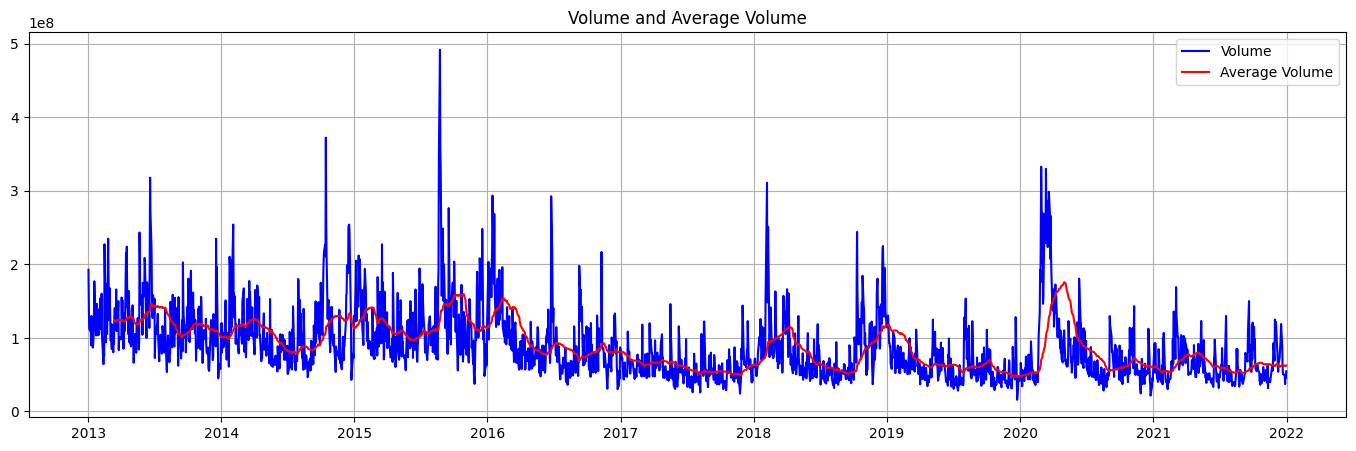

In [27]:
average_volume = training_data['volume'].rolling(window=50).mean()
plt.figure(figsize=(17, 5))
plt.plot(training_data['volume'], label='Volume', color='blue')
plt.plot(average_volume, label='Average Volume', color='red')
plt.title('Volume and Average Volume')
plt.legend()
plt.grid()
plt.show()
